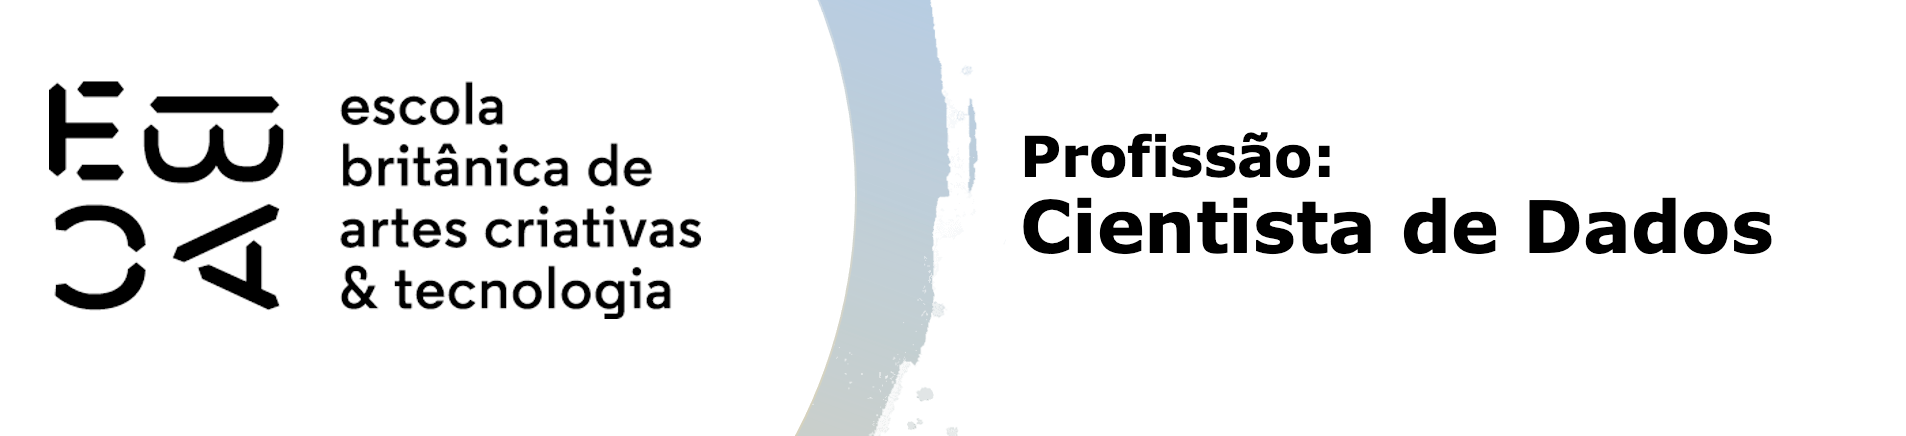

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from scipy.stats import ks_2samp

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [11]:
# Converter a variável data_ref para datetime para facilitar a manipulação
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Ordenar os dados pela data de referência, garantindo que a separação OOT seja correta
df = df.sort_values(by='data_ref')

# Definir a data limite para separar os três últimos meses como OOT
data_limite = df['data_ref'].max() - pd.DateOffset(months=3)

# Criar os conjuntos de treino e validação
train_df = df[df['data_ref'] <= data_limite]  # Dados antes dos últimos 3 meses
oot_df = df[df['data_ref'] > data_limite]    # Últimos 3 meses para validação

# Remover variáveis que não devem ser usadas na modelagem
variaveis_explicativas = df.columns.difference(['data_ref', 'index'])

# Exibir a divisão das bases
print(f"Tamanho da base de treino: {train_df.shape}")
print(f"Tamanho da base OOT: {oot_df.shape}")

Tamanho da base de treino: (600000, 15)
Tamanho da base OOT: (150000, 15)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [13]:
# Descritiva básica univariada
print("\nNúmero total de linhas na base de dados:", df.shape[0])
print("\nNúmero de linhas para cada mês em data_ref:")
print(df['data_ref'].value_counts().sort_index())

# Descrição das variáveis quantitativas
descricao_quantitativas = df.describe()
print("\nResumo estatístico das variáveis quantitativas:")
print(descricao_quantitativas)

# Descrição das variáveis qualitativas
variaveis_qualitativas = df.select_dtypes(include=['object', 'bool']).columns
descricao_qualitativas = df[variaveis_qualitativas].describe()
print("\nResumo estatístico das variáveis qualitativas:")
print(descricao_qualitativas)


Número total de linhas na base de dados: 750000

Número de linhas para cada mês em data_ref:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

Resumo estatístico das variáveis quantitativas:
                  data_ref          index     qtd_filhos          idade  \
count               750000  750000.000000  750000.000000  750000.000000   
mean   2015-08-01 06:24:00    8319.272793       0.433251      43.804733   
min    2015-01-01 00:00:00       0.000000       0.000000      22.000000   
25%    2015-04-01 00:00:00    4147.000000       0.000000      34.000000   
50%    2015-08-01 00:00:00    8324.000000       0.000000      43.000000   
75%    2015-12-01 00:00:00   12487.000000       1.000000      53.000000 

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável


Análise descritiva bivariada:

Correlação das variáveis quantitativas com 'mau':
mau                      1.000000
index                    0.009360
qtd_filhos               0.007018
qt_pessoas_residencia    0.003878
idade                   -0.027989
renda                   -0.067978
tempo_emprego           -0.132118
Name: mau, dtype: float64


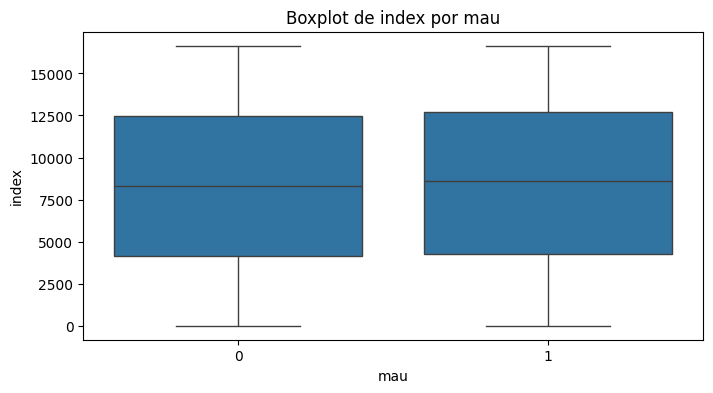

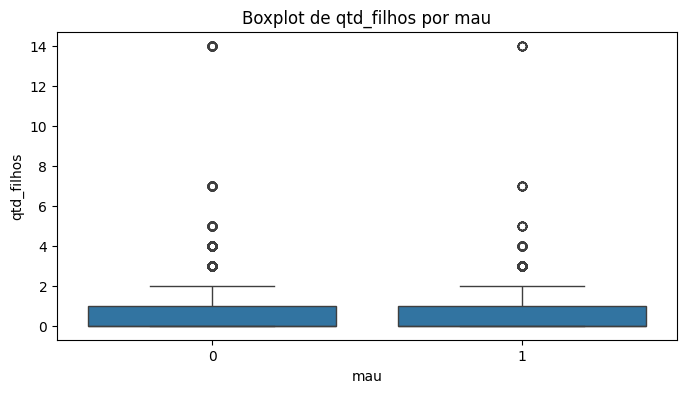

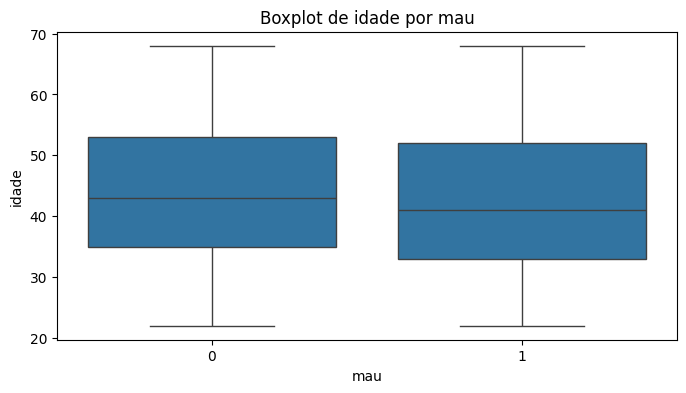

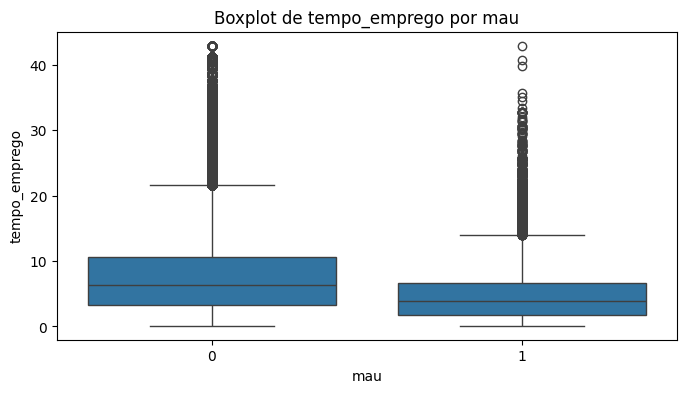

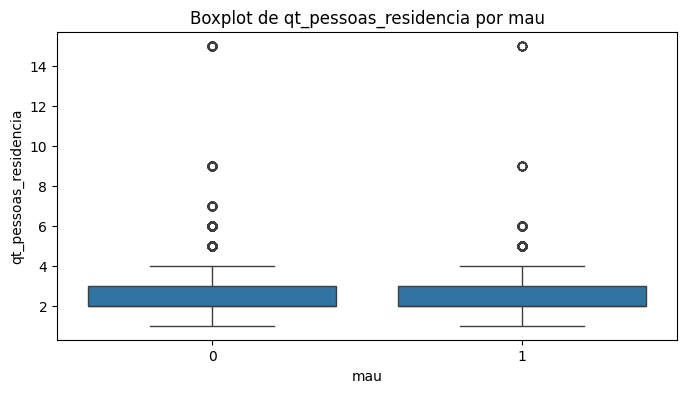

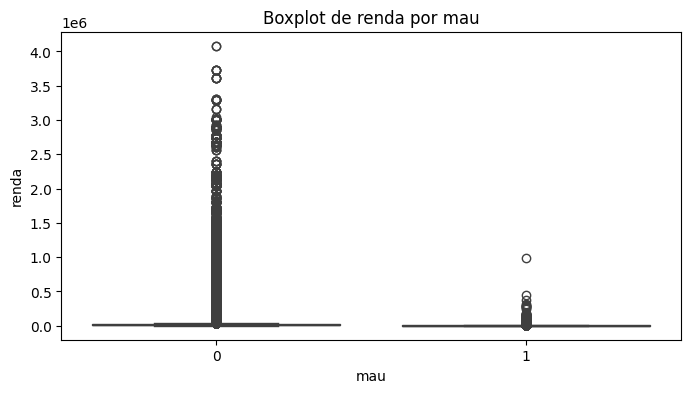

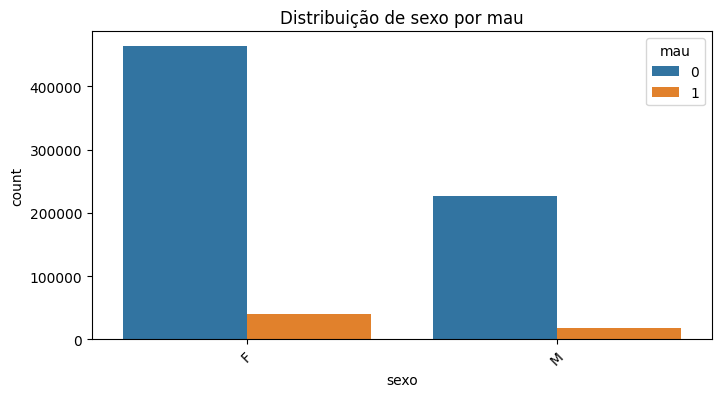

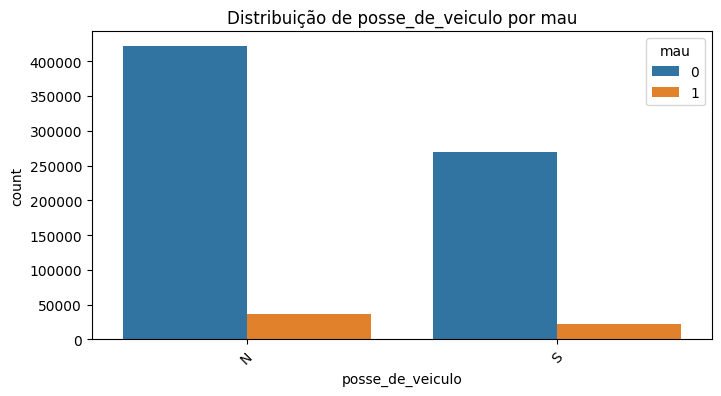

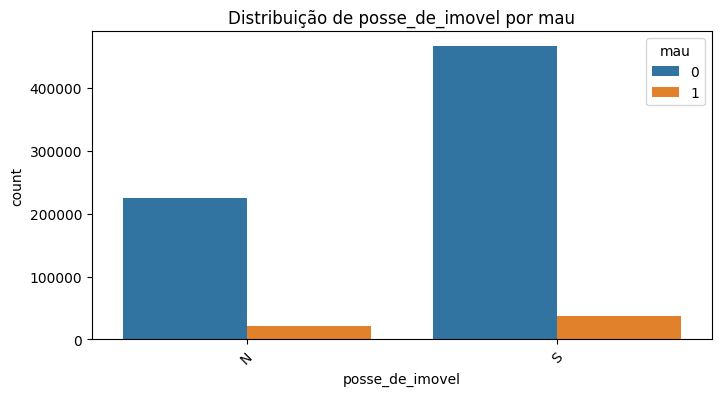

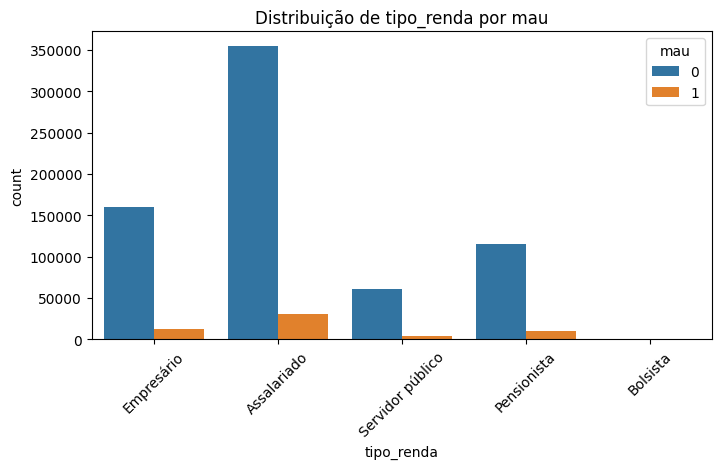

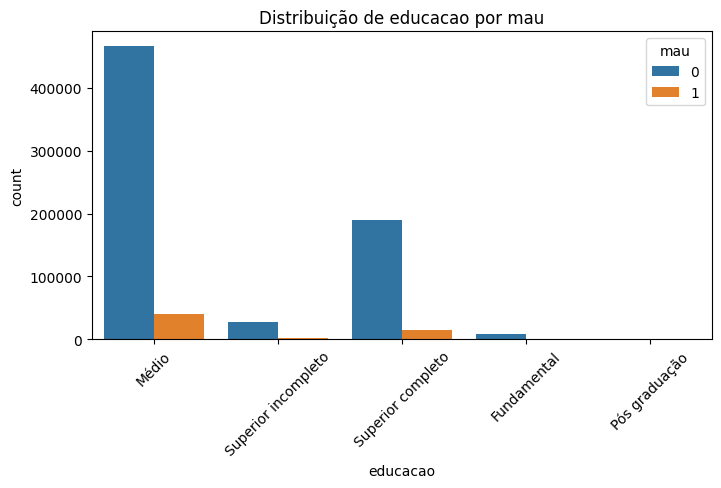

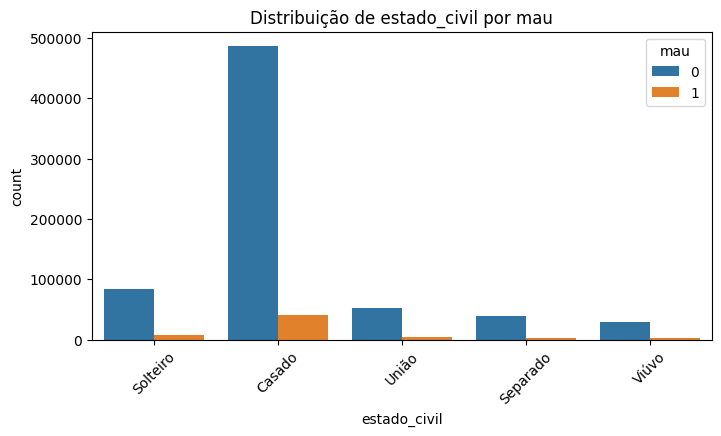

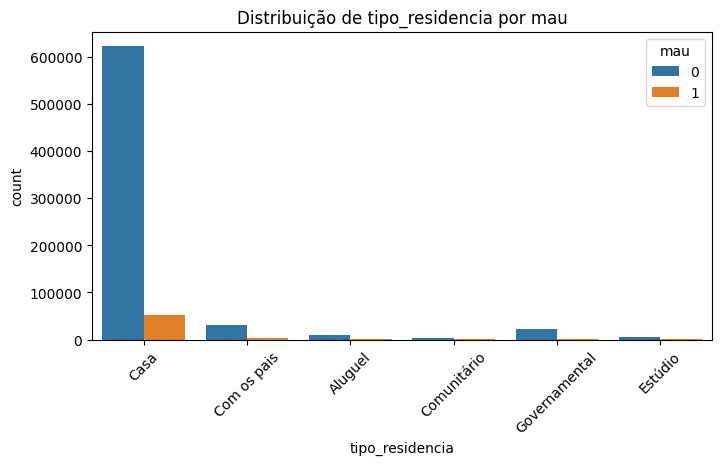

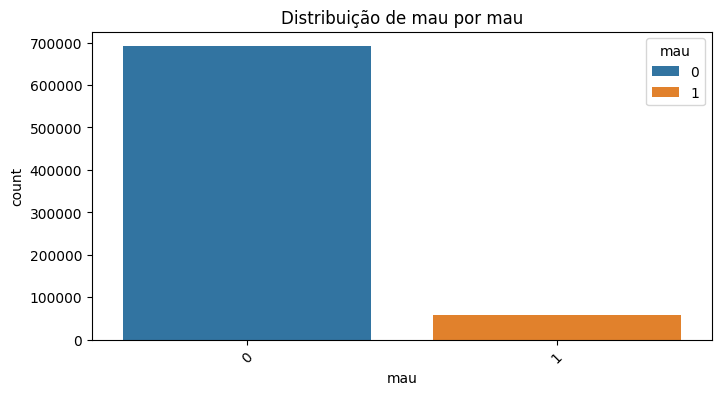

In [19]:
# Descritiva bivariada
print("\nAnálise descritiva bivariada:")
variavel_target = 'mau'

# Converter 'mau' para numérico (caso seja booleano)
df[variavel_target] = df[variavel_target].astype(int)

# Selecionar apenas variáveis numéricas para calcular a correlação
variaveis_numericas = df.select_dtypes(include=['float64', 'int64']).columns
correlacoes = df[variaveis_numericas].corr()[variavel_target].sort_values(ascending=False)
print("\nCorrelação das variáveis quantitativas com 'mau':")
print(correlacoes)

# Boxplots para variáveis quantitativas
for col in variaveis_numericas:
    if col != variavel_target:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[variavel_target], y=df[col])
        plt.title(f"Boxplot de {col} por {variavel_target}")
        plt.show()

# Gráficos de contagem para variáveis qualitativas
for col in variaveis_qualitativas:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col], hue=df[variavel_target])
    plt.title(f"Distribuição de {col} por {variavel_target}")
    plt.xticks(rotation=45)
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [2]:
# Separar os últimos 3 meses como OOT
data_limite = df['data_ref'].max() - pd.DateOffset(months=3)
train_df = df[df['data_ref'] <= data_limite]
oot_df = df[df['data_ref'] > data_limite]

# Remover variáveis desnecessárias
variaveis_explicativas = df.columns.difference(['data_ref', 'index'])
variavel_target = 'mau'
df[variavel_target] = df[variavel_target].astype(int)

# Identificar variáveis numéricas e categóricas
variaveis_numericas = df.select_dtypes(include=['float64', 'int64']).columns.difference(['mau'])
variaveis_categoricas = df.select_dtypes(include=['object']).columns

# Tratar valores missing
imputer_numerico = SimpleImputer(strategy='median')
imputer_categorico = SimpleImputer(strategy='most_frequent')

# Criar pré-processamento para variáveis numéricas e categóricas
preprocessador = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', imputer_numerico), ('scaler', StandardScaler())]), variaveis_numericas),
        ('cat', Pipeline([('imputer', imputer_categorico), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), variaveis_categoricas)
    ]
)

# Separar variáveis preditoras e alvo
X = df[variaveis_numericas.tolist() + variaveis_categoricas.tolist()]
y = df['mau']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Criar pipeline com modelo de regressão logística
modelo = Pipeline([
    ('preprocessador', preprocessador),
    ('classificador', LogisticRegression(solver='liblinear'))
])

# Treinar modelo
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred_train = modelo.predict(X_train)
y_proba_train = modelo.predict_proba(X_train)[:, 1]
y_pred_test = modelo.predict(X_test)
y_proba_test = modelo.predict_proba(X_test)[:, 1]

# Avaliação do modelo
print("\nRelatório de Classificação (Treino):")
print(classification_report(y_train, y_pred_train, zero_division=0))
print(f"Acurácia (Treino): {accuracy_score(y_train, y_pred_train):.4f}")

print("\nRelatório de Classificação (Teste):")
print(classification_report(y_test, y_pred_test, zero_division=0))
print(f"Acurácia (Teste): {accuracy_score(y_test, y_pred_test):.4f}")

# Calcular AUC-ROC
print(f"AUC-ROC (Treino): {roc_auc_score(y_train, y_proba_train):.4f}")
print(f"AUC-ROC (Teste): {roc_auc_score(y_test, y_proba_test):.4f}")

# Calcular KS
ks_train = ks_2samp(y_proba_train[y_train == 1], y_proba_train[y_train == 0]).statistic
ks_test = ks_2samp(y_proba_test[y_test == 1], y_proba_test[y_test == 0]).statistic
print(f"KS (Treino): {ks_train:.4f}")
print(f"KS (Teste): {ks_test:.4f}")

# Calcular Gini
gini_train = 2 * roc_auc_score(y_train, y_proba_train) - 1
gini_test = 2 * roc_auc_score(y_test, y_proba_test) - 1
print(f"Gini (Treino): {gini_train:.4f}")
print(f"Gini (Teste): {gini_test:.4f}")

# Avaliação na base OOT
X_oot = oot_df[variaveis_numericas.tolist() + variaveis_categoricas.tolist()]
y_oot = oot_df['mau']

# Aplicar o modelo na base OOT
y_pred_oot = modelo.predict(X_oot)
y_proba_oot = modelo.predict_proba(X_oot)[:, 1]

# Avaliação do modelo na base OOT
print(f"Acurácia (OOT): {accuracy_score(y_oot, y_pred_oot):.4f}")
print(f"AUC-ROC (OOT): {roc_auc_score(y_oot, y_proba_oot):.4f}")

# Calcular KS
ks_oot = ks_2samp(y_proba_oot[y_oot == 1], y_proba_oot[y_oot == 0]).statistic
print(f"KS (OOT): {ks_oot:.4f}")

# Calcular Gini
gini_oot = 2 * roc_auc_score(y_oot, y_proba_oot) - 1
print(f"Gini (OOT): {gini_oot:.4f}")



Relatório de Classificação (Treino):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    553086
           1       0.00      0.00      0.00     46914

    accuracy                           0.92    600000
   macro avg       0.46      0.50      0.48    600000
weighted avg       0.85      0.92      0.88    600000

Acurácia (Treino): 0.9218

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    138271
           1       0.00      0.00      0.00     11729

    accuracy                           0.92    150000
   macro avg       0.46      0.50      0.48    150000
weighted avg       0.85      0.92      0.88    150000

Acurácia (Teste): 0.9218
AUC-ROC (Treino): 0.7761
AUC-ROC (Teste): 0.7774
KS (Treino): 0.4148
KS (Teste): 0.4182
Gini (Treino): 0.5523
Gini (Teste): 0.5549
Acurácia (OOT): 0.8533
AUC-ROC (OOT): 0.7262
KS (OOT): 0.3307
Gini (OOT): 0.4525


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

### Avaliação do Modelo de Credit Scoring

#### **Métricas do Modelo**
#### **Desempenho na Base de Treinamento**
- **Acurácia**: 92,18%
- **AUC-ROC**: 0.7761
- **KS**: 0.4148
- **Gini**: 0.5523

#### **Desempenho na Base de Teste**
- **Acurácia**: 92,18%
- **AUC-ROC**: 0.7774
- **KS**: 0.4182
- **Gini**: 0.5549

#### **Desempenho na Base OOT**
- **Acurácia**: 85,33%
- **AUC-ROC**: 0.7262
- **KS**: 0.3307
- **Gini**: 0.4525

---

### **Análise dos Resultados**
#### **Acurácia**
O modelo apresenta uma **acurácia de 92%** na base de treino e teste, mas cai para **85,33% na base OOT**. Isso sugere que o modelo pode estar **superajustado aos dados de treino e teste**, não generalizando tão bem para novos períodos.

#### **AUC-ROC e Gini**
- O **AUC-ROC** diminuiu de aproximadamente **0.77 para 0.72 na base OOT**, indicando que o modelo perdeu parte de sua capacidade de discriminação ao ser testado em novos dados.
- O **Gini**, que é derivado do AUC-ROC, também caiu de **0.55 para 0.45**, reforçando a queda na performance preditiva.

#### **KS (Kolmogorov-Smirnov)**
- O **KS caiu de 0.42 para 0.33 na base OOT**, indicando que a separação entre classes no conjunto de validação é mais fraca em comparação com treino e teste.
- Modelos bons geralmente apresentam KS **acima de 0.4**, o que significa que a performance na base OOT pode não ser satisfatória.

#### **Problema com a Classificação de Inadimplentes**
O **F1-score dos inadimplentes (classe 1) é 0**, ou seja, o modelo **não consegue prever corretamente clientes inadimplentes**. Isso indica que o modelo pode estar **extremamente enviesado para a classe majoritária (adimplentes - classe 0)**.

### **Possíveis Melhorias**
1. **Balanceamento da base**
   - Utilizar técnicas de *oversampling* (SMOTE) para aumentar a representatividade da classe minoritária.
   - Testar *undersampling* para reduzir o domínio da classe majoritária e equilibrar os pesos.

2. **Ajuste do Threshold de Decisão**
   - Alterar o **threshold de decisão** para tornar o modelo mais sensível à classe 1.
   - Testar limiares diferentes para melhorar o recall da classe de inadimplentes.

3. **Testar Algoritmos Mais Robustos**
   - Modelos baseados em árvores de decisão, como **Random Forest, XGBoost ou LightGBM**, podem lidar melhor com classes desbalanceadas.
   - Implementar modelos que considerem a estrutura temporal dos dados, como **Redes Neurais Recorrentes (RNNs) ou Modelos Bayesianos Dinâmicos**.

4. **Engenharia de Features**
   - Criar novas variáveis baseadas em comportamento passado para melhorar a capacidade preditiva.
   - Testar diferentes métodos de imputação de valores faltantes e normalização de variáveis categóricas.

Em resumo, o modelo precisa de ajustes para melhorar a previsão de inadimplentes, pois atualmente está excessivamente enviesado para a classe majoritária e perde desempenho ao ser avaliado em períodos futuros (OOT).